In [ ]:
!pip install 'tensorflow<2.0.0'

     |████████████████████████████████| 110.5 MB 1.1 kB/s 
     |████████████████████████████████| 20.1 MB 2.1 MB/s 
     |████████████████████████████████| 503 kB 49.1 MB/s 
     |████████████████████████████████| 3.8 MB 30.9 MB/s 
     |████████████████████████████████| 2.9 MB 34.8 MB/s 
     |████████████████████████████████| 50 kB 5.8 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=318046e5399a4b5b47164a7def73aa5483feb6c8f363375edd397d2b7f6322eb
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tens

In [ ]:
!pip install tensorrec

  Attempting uninstall: six
    Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-probability 0.16.0 requires gast>=0.3.2, but you have gast 0.2.2 which is incompatible.
kapre 0.3.7 requires tensorflow>=2.0.0, but you have tensorflow 1.15.5 which is incompatible.
google-colab 1.0.0 requires six~=1.15.0, but you have six 1.11.0 which is incompatible.
google-api-python-client 1.12.11 requires six<2dev,>=1.13.0, but you have six 1.11.0 which is incompatible.
google-api-core 1.31.5 requires six>=1.13.0, but you have six 1.11.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
# Import the standard packages normally utilize by Data Scientist
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn import preprocessing
from collections import Counter
import scipy.sparse as sparse

# os is a handy module to explore operating system directory
import os

# import keras as the Tensorflow engine uses Keras Neural Net backend
from tensorflow import keras as ks 


# Import Tensorrec recommendation packages
import tensorrec
from tensorrec import TensorRec
from tensorrec.eval import *
from tensorrec.util import append_to_string_at_point

### the rest of these representation graphs are also available as an alternative
### feel free to play around to tune up the model
from tensorrec.representation_graphs import (AbstractKerasRepresentationGraph, 
#                                              ReLURepresentationGraph, 
                                             NormalizedLinearRepresentationGraph, 
#                                              LinearRepresentationGraph
                                            )

from tensorrec.loss_graphs import (WMRBLossGraph, 
#                                    BalancedWMRBLossGraph,
#                                    RMSELossGraph, 
#                                    RMSEDenseLossGraph, 
#                                    SeparationDenseLossGraph
                                  ) 

from tensorrec.eval import fit_and_eval, eval_random_ranks_on_dataset
from tensorrec.util import append_to_string_at_point

### we need to construct a Keras representation graph by inheriting tensorrec.representation_graphs.AbstractKerasRepresentationGraph
### https://www.tensorflow.org/tensorboard/graphs
### many thanks to James Kirk for his article: 
### https://medium.com/hackernoon/deep-learning-for-recommendation-with-keras-and-tensorrec-2b8935c795d0

class DeepRepresentationGraph(AbstractKerasRepresentationGraph):

    # This method returns an ordered list of Keras layers connecting the user/item features to the user/item
    # representation. When TensorRec learns, the learning will happen in these layers.
    def create_layers(self, n_features, n_components):
        return [
            ks.layers.Dense(n_components * 16, activation='relu'), #rectified linear unit
            ks.layers.Dense(n_components * 8, activation='relu'), #you can try other activation layer too
            ks.layers.Dense(n_components * 2, activation='relu'), #most likely changes only benefit other ML like image recog.
            ks.layers.Dense(n_components, activation='tanh'),
        ]

In [ ]:
data = pd.read_csv('merged data.csv')

**EDA(Explaratory Data Analysis)**

# New Section

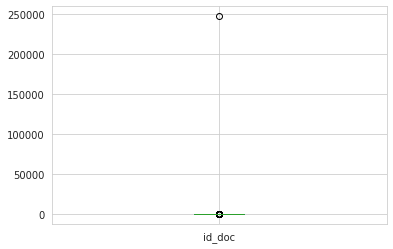

In [ ]:
out = data.groupby('id_card_x')[['id_doc']].nunique()
out = out.reset_index()
boxplot = out.boxplot(column = ['id_doc'])

In [ ]:
out.max()

id_card_x    a869620   
id_doc           246938
dtype: object

In [ ]:
 out.drop(out[out['id_doc'] == 246938 ].index, inplace = True)

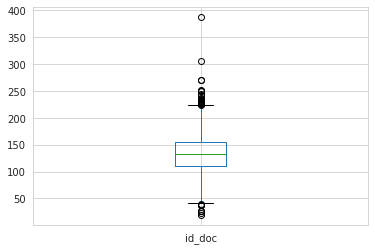

In [ ]:
boxplot = out.boxplot(column = ['id_doc'])

In [ ]:
# As we can see it would be meaningful to drop the id_doc 246938 from the original data 

data.drop(data[data['id_doc'] == 246938].index, inplace = True)

In [ ]:
data.drop(data[data['id_card_x'] == '4806534'].index, inplace = True)

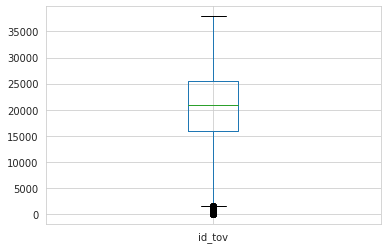

In [ ]:
# Now we need to see the oultiers in the items
out_1 = data.groupby('id_tov')[['sum']].sum()
out_1 = out_1.reset_index()
out_1.boxplot(column = ['id_tov'])

In [ ]:
data.head()

,id_doc,id_card_x,id_tov,quantity,sum,sum of doc,date
1,300F2961-E2EB-EA11-B444-005056A7539A,1123834,26904,1.0,195.0,195.0,9/1/2020 2:32
2,4DCB33F0-E4EB-EA11-B444-005056A7539A,1123834,23585,1.0,126.0,191.0,9/1/2020 2:51
26,773417AE-09EC-EA11-B444-005056A7539A,6671470,17736,1.0,37.8,292.8,9/1/2020 7:04
27,773417AE-09EC-EA11-B444-005056A7539A,6671470,20698,1.0,96.0,292.8,9/1/2020 7:04
28,773417AE-09EC-EA11-B444-005056A7539A,6671470,15433,1.0,24.0,292.8,9/1/2020 7:04


**Data Preparation**

**RFMV(Resency, Frequency, Monetary, Variaty)**

In [ ]:
data['Date'] =  pd.DatetimeIndex(data['Transaction Date']).date

In [ ]:
data = data[data['Date'].notnull()]

In [ ]:
data['Date']

0         2020-09-01
1         2020-09-01
2         2020-09-01
3         2020-09-01
4         2020-09-01
             ...    
279379    2020-11-30
279380    2020-11-30
279381    2020-11-30
279382    2020-11-30
279383    2020-11-30
Name: Date, Length: 279384, dtype: object

In [ ]:
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')

In [ ]:
import datetime as dt

date = dt.date(2020, 12, 1) # just take the max date from the index + 1
date = pd.to_datetime(date, format = '%Y-%m-%d')

In [ ]:
#Recency

recency_df = data.groupby('Customer ID')['Date'].max().reset_index()
recency_df.columns = ['Customer ID','Last Purchase']
recency_df['Recency'] = recency_df['Last Purchase'].apply(lambda x: (date - x).days)
recency_df = recency_df[['Customer ID', 'Recency']]
recency_df

,Customer ID,Recency
0,0000814,1
1,0000864,1
2,0004728,1
3,0008617,3
4,0020717,1
...,...,...
994,B797512,1
995,C312331,1
996,a238131,1
997,a318512,1


In [ ]:
# FREQUENCY

frequency_df = data.groupby('Customer ID')['Date'].count().reset_index()
frequency_df.columns = ['Customer ID','Frequency']
frequency_df.head()

,Customer ID,Frequency
0,0000814,299
1,0000864,451
2,0004728,225
3,0008617,427
4,0020717,245


In [ ]:
# MONETARY

monetary_df = data.groupby('Customer ID')['Sum of doc'].sum().reset_index()
monetary_df.columns = ['Customer ID','Monetary']
monetary_df.head()

,Customer ID,Monetary
0,0000814,210906.95
1,0000864,927996.53
2,0004728,138361.80
3,0008617,521259.29
4,0020717,147743.88


In [ ]:
# # VARIETY

variety_df = data.groupby('Customer ID')['Item ID'].nunique().reset_index()
variety_df.columns = ['Customer ID','Variety']
variety_df.head()

,Customer ID,Variety
0,0000814,58
1,0000864,132
2,0004728,57
3,0008617,98
4,0020717,62


In [ ]:
rfmv = recency_df.copy()

rfmv = rfmv.merge(frequency_df, on='Customer ID')
rfmv = rfmv.merge(monetary_df, on='Customer ID')
rfmv = rfmv.merge(variety_df, on='Customer ID')
rfmv.head(5)

,Customer ID,Recency,Frequency,Monetary,Variety
0,0000814,1,299,210906.95,58
1,0000864,1,451,927996.53,132
2,0004728,1,225,138361.80,57
3,0008617,3,427,521259.29,98
4,0020717,1,245,147743.88,62


In [ ]:
### we take the 25%, 50%, and 75% quantile for each of R, F, M, and V and store them into dictionary data type
rfmv_quantiles = rfmv.iloc[:, 1:].quantile(q = [0.25, 0.5, 0.75]).to_dict()
rfmv_quantiles

{'Frequency': {0.25: 184.0, 0.5: 255.0, 0.75: 357.0},
 'Monetary': {0.25: 59239.015, 0.5: 111009.72, 0.75: 213820.39},
 'Recency': {0.25: 1.0, 0.5: 1.0, 0.75: 1.0},
 'Variety': {0.25: 52.0, 0.5: 72.0, 0.75: 90.0}}

In [ ]:
## create a function that returns a score--0 to 4 based on the quartile ranking
## these score can be easily interpreted by the K-Mean algorithm instead of the actual value of RFMB

### recency score: the lower the recency, the higher the score 
def RecencyScore(i, col, df):
    if i <= df[col][0.25]:
        return 4
    elif i <= df[col][0.50]:
        return 3
    elif i <= df[col][0.75]: 
        return 2
    else:
        return 1
    
# F, M, V: In contrast to Recency, the higher the quantile value, the higher the score    
def FMVScore(i, col, df):
    if i <= df[col][0.25]:
        return 1
    elif i <= df[col][0.50]:
        return 2
    elif i <= df[col][0.75]: 
        return 3    
    else:
        return 4

In [ ]:
rfmv2 = rfmv.copy()

rfmv2['R_q'] = rfmv2['Recency'].apply(RecencyScore, args=('Recency', rfmv_quantiles ))
rfmv2['F_q'] = rfmv2['Frequency'].apply(FMVScore, args=('Frequency', rfmv_quantiles ))
rfmv2['M_q'] = rfmv2['Monetary'].apply(FMVScore, args=('Monetary', rfmv_quantiles ))
rfmv2['V_q'] = rfmv2['Variety'].apply(FMVScore, args=('Variety', rfmv_quantiles ))

rfmv2 = rfmv2[['Customer ID', 'R_q', 'F_q', 'M_q', 'V_q',]]

# # Sum total scores of each component

rfmv2['Total_Score'] = rfmv2['R_q'] + rfmv2['F_q'] + rfmv2['M_q'] + rfmv2['V_q']

rfmv2 = rfmv2[['Customer ID', 'Total_Score']]

# IMPORTANT: set index to customer number
rfmv2.index = rfmv2['Customer ID']
rfmv2 = rfmv2.drop('Customer ID', 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [ ]:
rfmv2.head()

,Total_Score
Customer ID,
0000814,12
0000864,16
0004728,11
0008617,13
0020717,11


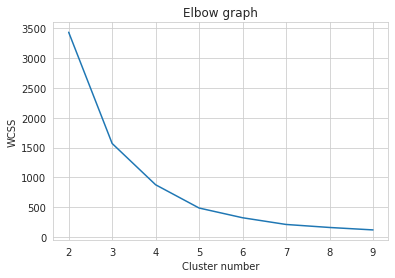

In [ ]:
# We use elbow method to find the optimal number of clusters

wcss = []
for i in range(2,10):
    kmeans = KMeans(n_clusters=i, 
                    init='k-means++')
    kmeans.fit(rfmv2)
    wcss.append(kmeans.inertia_)
    
# Plot the graph for Elbow Method
plt.plot(range(2,10), wcss)
plt.title('Elbow graph')
plt.xlabel('Cluster number')
plt.ylabel('WCSS')
plt.show()

In [ ]:
# Apply KMean clustering using the optimal number with the "elbow" on the graph above
kmeans = KMeans(n_clusters=4, 
                init='random', 
                random_state=None)

clusters = kmeans.fit_predict(rfmv2)

### add the cluster result to the original rfmv dataframe
rfmv['Clusters'] = clusters

In [ ]:
rfmv.head(5)

,Customer ID,Recency,Frequency,Monetary,Variety,Clusters
0,0000814,1,299,210906.95,58,2
1,0000864,1,451,927996.53,132,1
2,0004728,1,225,138361.80,57,2
3,0008617,3,427,521259.29,98,2
4,0020717,1,245,147743.88,62,2


In [ ]:

Counter(clusters)

Counter({0: 118, 1: 263, 2: 357, 3: 261})

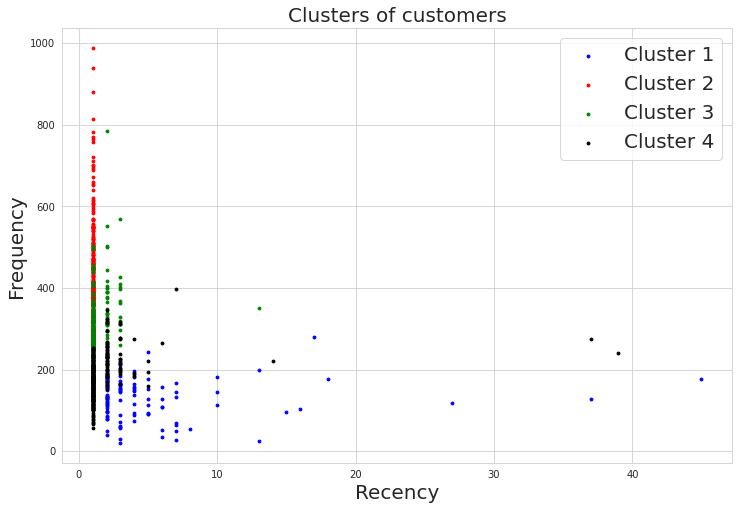

In [ ]:
## optional: plot the two components with their respective RFMV to see the shape of the clusters
## optional: you can try to plot other RFMV components too

fig, ax = plt.subplots(figsize=(12,8))

var1 = 'Recency'
var2 = 'Frequency'
temp = rfmv.copy()

c1 = temp[temp.Clusters == 0]
c2 = temp[temp.Clusters == 1]
c3 = temp[temp.Clusters == 2]
c4 = temp[temp.Clusters == 3]

# Visualization of the clusters
plt.scatter(c1[var1], c1[var2], c = 'b', label = 'Cluster 1', s=8)
plt.scatter(c2[var1], c2[var2], c = 'r', label = 'Cluster 2', s=8)
plt.scatter(c3[var1], c3[var2], c = 'g', label = 'Cluster 3', s=8)
plt.scatter(c4[var1], c4[var2], c = 'k', label = 'Cluster 4', s=8)

plt.title('Clusters of customers', size=20)
plt.xlabel(var1, size=20)
plt.ylabel(var2, size=20)
plt.legend(fontsize=20)

In [ ]:
# Try based on the Item ID (than try on group category)

### merge customer features--clusters and city--into master data

cleaned_df = data.merge(rfmv[['Customer ID','Clusters']], how='left', on='Customer ID')

## removed any null entries on clusters (if any)
cleaned_df = cleaned_df[cleaned_df['Clusters'].notnull()]

In [ ]:
final_cleaned_df = cleaned_df

final_cleaned_df = final_cleaned_df[['Item ID','Quantity','Customer ID','Clusters','Document ID']]

cust_grouped = final_cleaned_df.groupby(['Customer ID',
                                         'Document ID',
                                         'Item ID',
                                        'Clusters']).sum().reset_index()

In [ ]:
### Interaction Matrix 
# Getting the Customer's transaction for every material interms of sales quantity
interactions = cust_grouped.groupby(['Customer ID', 'Item ID'])['Quantity'].sum().unstack().fillna(0)

# Scale value of the interaction matrix using sklearn.preprocessing.MinMaxScaler 
minmaxscaler = preprocessing.MinMaxScaler()
interactions_scaled = minmaxscaler.fit_transform(interactions)
interactions_scaled = pd.DataFrame(interactions_scaled)

## The scaled matrix lost the index (customer) and column (item) information
## we re-append the customer ID and the material into the DataFrame's index and column respectively
interactions_scaled.index = interactions.index
interactions_scaled.columns = interactions.columns

In [ ]:
### User Features Matrix 
## There are two features that is used to build the user matrix here
## First is the customer's unique categories they buy 
## Second is the clusters they belong to

# Getting the unique categories they buy
# grouped them by the quantity per category
cust_qty = cust_grouped.groupby(['Customer ID', 'Item ID'])['Quantity'].sum().unstack().fillna(0)

# Scaled value of the categories
# Scale value of the interaction matrix using sklearn.preprocessing.MinMaxScaler 
minmaxscaler = preprocessing.MinMaxScaler()
cust_qty_scaled = minmaxscaler.fit_transform(cust_qty)
cust_qty_scaled = pd.DataFrame(cust_qty_scaled)
cust_qty_scaled.index = cust_qty.index
cust_qty_scaled.columns = cust_qty.columns

## Include the Cluster features of the customers
## this is the additional feature that we want to add into the user feature
## the cluster serves as customer's "characteristics"
### we use groupby/nunique aggregation to get a one-hot encoding of each customer's clusters

cust_clus = cust_grouped.groupby(['Customer ID', 'Clusters'])['Clusters'].nunique().unstack().fillna(0)
cust_clus

# Merge the two features to create the user feature matrix
customer_features = pd.merge(cust_qty_scaled, cust_clus, left_index=True, right_index=True, how='inner')
customer_features = customer_features.rename(columns={0: 'Cluster 0', 
                                                      1: 'Cluster 1', 
                                                      2: 'Cluster 2', 
                                                      3: 'Cluster 3', 
                                                      4: 'Cluster 4'})

## as an additional practice, you can also include other user information from custdf, such as gender and date of birth
## but for now, I will omit those information

In [ ]:
frequency_per_document = cust_grouped.groupby(['Document ID']).agg({'Item ID': list}).assign(count=lambda x: x['Item ID'].str.len())

In [ ]:
frequency_per_document["Item ID"] = frequency_per_document["Item ID"].astype(str)

In [ ]:
frequency_per_product = frequency_per_document.merge(cust_grouped, left_on="Document ID", right_on="Document ID")

In [ ]:
frequency_per_product = frequency_per_product[['Document ID','Item ID_x','Item ID_y']]

In [ ]:
item_category = pd.DataFrame(frequency_per_product.groupby(['Item ID_y', 'Item ID_x'])['Document ID'].count().unstack().fillna(0).reset_index().set_index('Item ID_y'))


In [ ]:
item_category.head()

Item ID_x,"[103, 1066, 17863]","[103, 1066, 21159, 26401, 37885]","[103, 1066]","[103, 1169]","[103, 120, 16319]","[103, 120]","[103, 1225, 15374, 25375]","[103, 1225, 16417, 22490]","[103, 1225, 18641]","[103, 1225, 19746]",...,"[933, 23995]","[933, 24680]","[933, 26751]","[933, 27215]","[933, 29624]","[933, 33009]","[933, 36467]","[933, 36971]","[933, 37318]",[933]
Item ID_y,,,,,,,,,,,,,,,,,,,,,
52,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
91,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:

# Scaled value of the item categories
minmaxscaler = preprocessing.MinMaxScaler()
item_category_scaled = minmaxscaler.fit_transform(item_category)
item_category_scaled = pd.DataFrame(item_category_scaled)
item_category_scaled.index = item_category.index
item_category_scaled.columns = item_category.columns

In [ ]:
### We have three features as required by TensorRec
### TensorRec accept matrix, and not dataframe, therefore we need to transform them into matrix

## Create COOMatrices using Scipy function 
## COOMatrices are sparse matrices, mostly filled with zero
## It speeds up the processes and saves a lot of memory
interaction_f = sparse.coo_matrix(interactions_scaled)
user_f  = sparse.coo_matrix(customer_features) 
item_f  = sparse.coo_matrix(item_category_scaled) 

In [ ]:
### Jesse Steinweg-Woods provide a great elaboration on Recommendation metrics
### The following code is borrowed from his work
### https://jessesw.com/Rec-System/

def interaction_masking(interactions):
    '''
    This function will "mask" (a.k.a "hide") 20% of original interactions
    Masked items wil be considered not purchased

    '''
    mask_size = len(interactions.data)
    mask = np.random.choice(a=[False, True], size=mask_size, p=[.2, .8])
    not_mask = np.invert(mask)

    train_interactions = sparse.coo_matrix((interactions.data[mask],
                                        (interactions.row[mask],
                                         interactions.col[mask])),
                                       shape=interactions.shape)

    test_interactions = sparse.coo_matrix((interactions.data[not_mask],
                                       (interactions.row[not_mask],
                                        interactions.col[not_mask])),
                                      shape=interactions.shape)

    return train_interactions, test_interactions

In [ ]:
mask_size = len(interaction_f.data)

### use numpy.random.choice to generate a random True/False array, where False denotes the "masked" interactions (hidden)
## https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.choice.html
np.random.choice(a=[False, True], 
                 size=mask_size, 
                 p=[.2, .8])

array([ True,  True,  True, ...,  True,  True,  True])

In [ ]:
# Create a masked train and test dataset of the interaction features
train_interactions, test_interactions = interaction_masking(interaction_f)

# Feed the user and item features
user_features  = user_f
item_features = item_f

In [ ]:
## validate that the interactions are scipy coordinate sparse matrix

train_interactions

<999x400 sparse matrix of type '<class 'numpy.float64'>'
	with 58335 stored elements in COOrdinate format>

In [ ]:

### call %%time to see the time it takes to run the model 

## model parameters

epochs = 1000#number of iterations ## play around with this number to achieve an optimal learning curve
alpha = 0.001 
n_components =400  ## play around with this number to achieve an optimal learning curve

verbose = True
learning_rates = 0.005
n_sampled_items = int(item_features.shape[0] * .1)
biased = False
 
k_val  = 100

## Approximation of WMRB: Learning to Rank in a Scalable Batch Training Approach .
### Interactions can be any positive values, but magnitude is ignored. Negative interactions are ignored
### http://ceur-ws.org/Vol-1905/recsys2017_poster3.pdf
#  Options: BalancedWMRBLossGraph,RMSELossGraph, RMSEDenseLossGraph, SeparationDenseLossGraph

model = TensorRec(n_components = n_components,                 
                  user_repr_graph = DeepRepresentationGraph(),
                   item_repr_graph = NormalizedLinearRepresentationGraph(),
                   loss_graph = WMRBLossGraph(), 
                  biased=biased)

model.fit(train_interactions, 
          user_features, 
          item_features, 
          epochs=epochs, 
          verbose=False, 
          alpha=alpha, 
          n_sampled_items=n_sampled_items,
          learning_rate =learning_rates)


# # Get predicted scores for all users and all items
# predictions = model.predict(user_features=user_features,
#                             item_features=item_features)

# Get the predicted rankings (First, second, third, and so forth...) for all users and all items
predicted_ranks = model.predict_rank(user_features=user_features,
                                     item_features=item_features)

/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [ ]:
predicted_ranks

array([[ 23,   6,  71, ..., 375, 350,  22],
       [111,  32,  50, ..., 266, 173, 278],
       [ 40,  11,  71, ..., 367, 359,  18],
       ...,
       [ 83,  31,  79, ..., 315, 318,  34],
       [132,  23,  31, ..., 215, 313,  11],
       [ 47,   7,  34, ..., 335, 246, 177]], dtype=int32)

In [ ]:
%%time

### TESTING

# we use Recall@k
# Recall@k: for the average user, what percentage of their test items made it in to the top k in the predicted rankings

# in other words, recall@k:
# what percentage of the positively interacted items (items purchased) were in the top k results of the prediction?

# in simpler words:
# Recall@k = (# of recommended items @k that are relevant) / (total # of relevant items)
#a.k.a
# Recall@k = (# of recommended items @k ) / (total # items purchased)

### reference: 

## optimally, if you have around 400-500 products, you want to achieve recall at k ≈ 200-250
## but since we only have 92 products, k=80 may sounds fitting.
r_at_k_test = recall_at_k(predicted_ranks, test_interactions, k=250)
r_at_k_train = recall_at_k(predicted_ranks, train_interactions, k=250)
print("Recall at @k: Train: {:.2f} Test: {:.2f}".format(r_at_k_train.mean(), r_at_k_test.mean()))

Recall at @k: Train: 0.88 Test: 0.87
CPU times: user 16.6 ms, sys: 0 ns, total: 16.6 ms
Wall time: 22.8 ms


In [ ]:
# produce the ranking into a readable table (dataframe it is)
ranks_df = pd.DataFrame(predicted_ranks)
ranks_df.columns = item_category_scaled.index
ranks_df.index = customer_features.index
ranks_df = ranks_df.T

In [ ]:
ranks_df.head()

Customer ID,0000814,0000864,0004728,0008617,0020717,0021380,0023305,0024526,0034354,0036058,...,B725460,B734167,B739945,B775916,B779802,B797512,C312331,a238131,a318512,a869620
Item ID_y,,,,,,,,,,,,,,,,,,,,,
52,23,111,40,41,167,90,70,22,215,27,...,158,204,45,36,61,108,246,83,132,47
61,6,32,11,20,37,29,23,5,56,5,...,30,54,2,9,7,26,123,31,23,7
69,71,50,71,121,36,60,73,54,39,54,...,28,24,32,56,22,47,43,79,31,34
91,80,260,108,202,48,151,187,122,122,111,...,125,86,35,155,47,232,147,212,36,181
103,68,198,91,192,27,126,164,104,69,96,...,49,28,23,129,28,183,81,175,20,131
